## AI Second major assignment 

In [1]:
import numpy as np
import pandas as pd
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import copy
from sklearn.metrics import accuracy_score,f1_score,roc_curve,precision_recall_curve,average_precision_score,auc
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,matthews_corrcoef,roc_auc_score
import matplotlib.pyplot as plt
import torch.utils.data as Data
from sklearn.model_selection import train_test_split

## 导入数据和数据增强

In [2]:
BATCH_SIZE = 32
np_test = np.load("test.npy")
np_train = np.load('train.npy')
#改维度，(numbers,channels,height,width)
np_test = np.reshape(np_test,(5000,1,28,28)).astype(float)
np_train = np.reshape(np_train,(30000,1,28,28))
train_label = pd.read_csv('train.csv')
train_label = train_label['label']
train_label = train_label.values
x_train,x_test,y_train,y_test = train_test_split(np_train,train_label,test_size=0.2,random_state=42)
#转成tensor
test_tensor = torch.from_numpy(x_test)
testlabel_tensor = torch.from_numpy(y_test)
train_tensor = torch.from_numpy(x_train)
trainlabel_tensor = torch.from_numpy(y_train)
# test_tensor = torch.from_numpy(np_test)
# train_tensor = torch.from_numpy(np_train)
# trainlabel_tensor = torch.from_numpy(train_label)
# trainlabel_tensor = torch.LongTensor(train_label)
# #建一个空的test标签来存test的输出
# testlabel_tensor = torch.from_numpy(np.zeros(5000))
#转one-hot的尝试
#one_hot = torch.zeros(30000, 10).scatter_(1, trainlabel_tensor.unsqueeze(-1), 1)
train_dataset = Data.TensorDataset(train_tensor,trainlabel_tensor)
test_dataset = Data.TensorDataset(test_tensor,testlabel_tensor)
#得到dataloder
#尝试自己写dataloder来做数据增强！！！
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

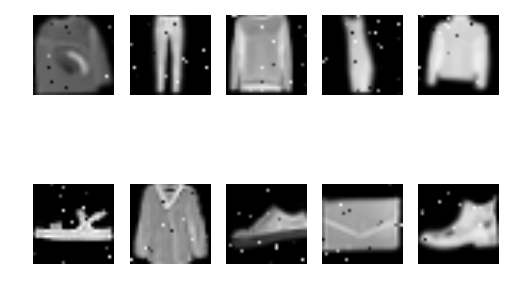

In [36]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg 
tr =  np.load('train.npy')
tr = np.reshape(np_train,(30000,1,28,28)).astype(float)
for i in range(10):
    plt.subplot(2,5,i+1)
    index = np.argwhere(train_label==i)
    img = tr[index[0]][0]
    plt.imshow(img[0],cmap='gray') # 显示灰度图片
    plt.axis('off') # 不显示坐标轴
plt.savefig('10classedimg')
plt.show()

### VGG网络层（新加入两层dropout）

In [3]:
#定义网络模型亦即Net 这里定义一个简单的全连接层784->10
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = nn.Conv2d(1,64,1,padding=1)#(32,1,28,28)->(32,64,28,28)?
        self.conv2 = nn.Conv2d(64,64,3,padding=1)#(32,64,28,28)->(32,64,28,28)
        self.pool1 = nn.MaxPool2d(2,2)#(32,64,28,28)->(32,64,14,14)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)#(32,128,14,14)->(32,128,14,14)
        self.pool2 = nn.MaxPool2d(2,2,padding=1)#(32,128,14,14)->(32,128,8,8)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        
        self.fc5 = nn.Linear(128*8*8,512)
        self.drop1 = nn.Dropout2d()#防止过拟合
        self.fc6 = nn.Linear(512,10)#输出是10维代表10类
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop1(x)
        
        x = x.view(-1,128*8*8) #将维度展成128*8*8以便进行线性拟合
        x = F.relu(self.fc5(x))
        x = self.drop1(x)
        x = self.fc6(x)
        
        return x
    # def __init__(self):
    #     super(Model,self).__init__()
    #     self.linear1 = nn.Linear(784,784)
    #     self.linear2 = nn.Linear(784,10)
    # def forward(self,X):
    #     X = F.relu(self.linear1(X))
    #     return F.relu(self.linear2(X))

    # def __init__(self):
    #     super(Model,self).__init__()
    #     self.linear1 = nn.Linear(784,784)
    #     self.linear2 = nn.Linear(784,784)
    #     self.linear3 = nn.Linear(784,10)
    # def forward(self,X):
    #     X = F.relu(self.linear1(X))
    #     X = F.relu(self.linear2(X))
    #     return F.relu(self.linear3(X))

#     def __init__(self):
#         super(Model,self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)
 
#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         #x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return x

### REsnet

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)
        self.drop1 = nn.Dropout2d(0.1)#防止过拟合
        

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.drop1(out)
        return out


def ResNet18():

    return ResNet(ResidualBlock)

In [6]:
torch.cuda.device

torch.cuda.device

In [7]:
model = Model()#.cuda() #实例化卷积层
model.cuda() 
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
loss.cuda()
optimizer = optim.SGD(model.parameters(),lr = 0.001)
num_epochs = 100

In [7]:
model = ResNet18()#.cuda() #实例化卷积层
model.cuda() 
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
loss.cuda()
optimizer = optim.SGD(model.parameters(),lr = 0.01)
num_epochs = 50

In [8]:
losses = [] 
acces = []
eval_losses = []
eval_acces = []

for echo in range(num_epochs):
    train_loss = 0   #定义训练损失
    train_acc = 0    #定义训练准确度
    model.train()    #将网络转化为训练模式
    for i,(X,label) in enumerate(train_loader):     #使用枚举函数遍历train_loader
        #X = X.view(-1,784)       #X:[64,1,28,28] -> [64,784]将X向量展平
        X = Variable(X.float()).cuda()          #包装tensor用于自动求梯度
        label = Variable(label).cuda()
        out = model(X)           #正向传播
        lossvalue = loss(out,label)         #求损失值
        optimizer.zero_grad()       #优化器梯度归零
        lossvalue.backward()    #反向转播，刷新梯度值
        optimizer.step()        #优化器运行一步，注意optimizer搜集的是model的参数
        
        #计算损失
        train_loss += float(lossvalue)      
        #计算精确度
        _,pred = out.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    print("echo:"+' ' +str(echo))
    print("lose:" + ' ' + str(train_loss / len(train_loader)))
    print("accuracy:" + ' '+str(train_acc / len(train_loader)))

echo: 0
lose: 0.8140236964623133
accuracy: 0.70275
echo: 1
lose: 0.5586537831624349
accuracy: 0.789375
echo: 2
lose: 0.46801504961649576
accuracy: 0.8227916666666667
echo: 3
lose: 0.40077807728449505
accuracy: 0.8457083333333333
echo: 4
lose: 0.33914152112603185
accuracy: 0.8692083333333334
echo: 5
lose: 0.2756977893312772
accuracy: 0.8915
echo: 6
lose: 0.22905468816310168
accuracy: 0.9104166666666667
echo: 7
lose: 0.19371680135279895
accuracy: 0.9200416666666666
echo: 8
lose: 0.15842362025380136
accuracy: 0.9320833333333334
echo: 9
lose: 0.13462688948834936
accuracy: 0.9410833333333334
echo: 10
lose: 0.12058221290415774
accuracy: 0.9453333333333334
echo: 11
lose: 0.10885100091310838
accuracy: 0.94675
echo: 12
lose: 0.09969027482749274
accuracy: 0.95325
echo: 13
lose: 0.08735997081547976
accuracy: 0.95575
echo: 14
lose: 0.08555369460893174
accuracy: 0.9571666666666667
echo: 15
lose: 0.08036212635963845
accuracy: 0.9591666666666666
echo: 16
lose: 0.08336983878879498
accuracy: 0.958125
e

In [9]:
# eval_loss = 0
# eval_acc = 0
label_all = None
pred_all = None
pred_pro_all = None
model.eval() #模型转化为评估模式
for X,label in test_loader:
    #X = X.view(-1,784)
    X = Variable(X).cuda()
    label = Variable(label.long()).cuda()
    #model.cuda()
    with torch.no_grad():
        testout = model(X.float())
    testloss = loss(testout,label)
    #eval_loss += float(testloss)

    _, pred = testout.max(1)
    if label_all is None:
        label_all = label
    else:
        label_all = torch.cat([label_all,label])

    if pred_all is None:
        pred_all = torch.cat([pred])
    else:
        pred_all = torch.cat([pred_all,pred])

    if pred_pro_all is None:
        pred_pro_all = torch.cat([F.sigmoid(testout)])
    else:
        pred_pro_all = torch.cat([pred_pro_all,F.sigmoid(testout)])
#     num_correct = (pred == label).sum()
#     acc = int(num_correct) / X.shape[0]
#     eval_acc += acc

y_test = label_all.cpu().detach().numpy()
#print(y_test)
y_pred = pred_all.cpu().detach().numpy()
#print(y_pred)
y_pred_pro = pred_pro_all.cpu().detach().numpy()

E:\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [10]:
print('ACC:%.7f' %accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision-macro:%.7f' %precision_score(y_true=y_test, y_pred=y_pred,average='macro'))
print('Recall-macro:%.7f' %recall_score(y_true=y_test, y_pred=y_pred,average='macro'))
print('F1-macro:%.7f' %f1_score(y_true=y_test, y_pred=y_pred,average='macro')) 

ACC:0.8708333
Precision-macro:0.8686280
Recall-macro:0.8700824
F1-macro:0.8689307


In [11]:
y_arr = y_pred;
index = np.arange(0,5000,1);
y_arr = y_arr.reshape(5000,1);
index = index.reshape(5000,1);
#index.shape
y_preday = np.hstack((index,y_arr));
y_preday
y_preddf = pd.DataFrame(y_preday)
y_preddf
tr_label = pd.read_csv('train.csv');
y_preddf.columns=['image_id','label'];
y_preddf
y_preddf.to_csv('test4.csv', sep=',', header=True, index=False)
#tr_label